In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

import torch
import torch.nn as nn
import torch.optim as optim

# ## Data Class for Logging Metrics

In [2]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

@dataclass
class TrainingMetrics:
    """Stores training metrics for either DQN or Contextual Bandit"""
    timesteps: List[int] = field(default_factory=list)
    rewards: List[float] = field(default_factory=list)
    cumulative_rewards: List[float] = field(default_factory=list)
    average_rewards: List[float] = field(default_factory=list)
    losses: List[Optional[float]] = field(default_factory=list)
    exploration_rates: List[Optional[float]] = field(default_factory=list)

class MetricsLogger:
    """Handles logging of training metrics for both algorithms"""
    def __init__(self, log_interval: int = 100):
        self.log_interval = log_interval
        self.metrics = defaultdict(TrainingMetrics)
        self.cum_rewards = defaultdict(float)
        
    def log_step(self, 
                 algorithm: str,
                 timestep: int, 
                 reward: float,
                 loss: Optional[float] = None,
                 exploration_rate: Optional[float] = None):
        """Log metrics for a single training step"""
        
        # Update cumulative reward
        self.cum_rewards[algorithm] += reward
        
        # Only log at specified intervals
        if timestep % self.log_interval == 0:
            metrics = self.metrics[algorithm]
            metrics.timesteps.append(timestep)
            metrics.rewards.append(reward)
            metrics.cumulative_rewards.append(self.cum_rewards[algorithm])
            metrics.average_rewards.append(self.cum_rewards[algorithm] / (timestep + 1))
            metrics.losses.append(loss)
            metrics.exploration_rates.append(exploration_rate)

def plot_comparison(logger: MetricsLogger, 
                   save_path: Optional[str] = None,
                   figsize: tuple = (15, 10),
                   window_size: int = 50):
    """Plot comparison of DQN vs Contextual Bandit performance"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('DQN vs Contextual Bandit Performance Comparison')
    
    # Plot settings
    algorithms = ['DQN', 'Contextual Bandit']
    colors = ['blue', 'red']
    
    # Reward plots
    ax = axes[0, 0]
    for alg, color in zip(algorithms, colors):
        metrics = logger.metrics[alg]
        if len(metrics.rewards) > 0:  # Check if we have data
            # Plot raw rewards
            ax.plot(metrics.timesteps, metrics.rewards, color=color, label=f'{alg} (raw)', alpha=0.3)
            
            # Calculate and plot rolling average only if we have enough data
            if len(metrics.rewards) >= window_size:
                rolling_mean = np.convolve(metrics.rewards, 
                                         np.ones(window_size)/window_size, 
                                         mode='valid')
                # Adjust timesteps to match rolling mean length
                valid_timesteps = metrics.timesteps[window_size-1:window_size-1+len(rolling_mean)]
                ax.plot(valid_timesteps, rolling_mean, 
                       color=color, label=f'{alg} (moving avg)')
    ax.set_title('Rewards per Step')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Reward')
    ax.legend()
    
    # Cumulative reward
    ax = axes[0, 1]
    for alg, color in zip(algorithms, colors):
        metrics = logger.metrics[alg]
        if len(metrics.cumulative_rewards) > 0:
            ax.plot(metrics.timesteps, metrics.cumulative_rewards, 
                   color=color, label=alg)
    ax.set_title('Cumulative Reward')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Cumulative Reward')
    ax.legend()
    
    # Average reward
    ax = axes[1, 0]
    for alg, color in zip(algorithms, colors):
        metrics = logger.metrics[alg]
        if len(metrics.average_rewards) > 0:
            ax.plot(metrics.timesteps, metrics.average_rewards, 
                   color=color, label=alg)
    ax.set_title('Average Reward')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Average Reward')
    ax.legend()
    
    # Loss/Exploration (DQN only)
    ax = axes[1, 1]
    metrics = logger.metrics['DQN']
    if len(metrics.losses) > 0:
        # Filter out None values for losses
        valid_losses = [(t, l) for t, l in zip(metrics.timesteps, metrics.losses) if l is not None]
        if valid_losses:
            timesteps_loss, losses = zip(*valid_losses)
            ax.plot(timesteps_loss, losses, color='blue', label='Loss')
    
    ax2 = ax.twinx()
    if len(metrics.exploration_rates) > 0:
        # Filter out None values for exploration rates
        valid_exp = [(t, e) for t, e in zip(metrics.timesteps, metrics.exploration_rates) 
                     if e is not None]
        if valid_exp:
            timesteps_exp, exp_rates = zip(*valid_exp)
            ax2.plot(timesteps_exp, exp_rates, color='green', label='Exploration Rate')
    
    ax.set_title('DQN Loss and Exploration Rate')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Loss')
    ax2.set_ylabel('Exploration Rate')
    
    # Combine legends for the last subplot
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if lines1 or lines2:
        ax.legend(lines1 + lines2, labels1 + labels2)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ## Data Loading Functions

#

In [3]:
def load_data(sample_fraction=0.01, random_state=42):
    """
    Load news and behaviors data from MIND dataset with optional sampling
    
    Args:
        sample_fraction: fraction of behaviors data to sample (default: 0.01)
        random_state: random seed for reproducibility (default: 42)
        
    Returns:
        news_df: DataFrame containing news articles
        behaviors_df: DataFrame containing user behaviors
    """
    # Read news data
    col_news = ['NewsId', 'Category', 'SubCat', 'Title', 'Abstract', 'url', 'TitleEnt', 'AbstractEnt']
    news_df = pd.read_csv('MINDsmall_train/news.tsv', sep='\t', header=None, names=col_news)
    
    # Read behaviors data
    col_behaviors = ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']
    behaviors_df = pd.read_csv('MINDsmall_train/behaviors.tsv', sep='\t', header=None, names=col_behaviors)
    behaviors_df = behaviors_df.sample(frac=sample_fraction, random_state=random_state)
    
    return news_df, behaviors_df

#

# ## Common Utility Functions

#

In [4]:
def extract_time_features(time_str):
    """
    Extract time-based features from timestamp
    
    Args:
        time_str: timestamp string in format '%m/%d/%Y %I:%M:%S %p'
        
    Returns:
        dict: containing hour, day_of_week, is_weekend features
    """
    time = datetime.strptime(time_str, '%m/%d/%Y %I:%M:%S %p')
    return {
        'hour': time.hour,
        'day_of_week': time.weekday(),
        'is_weekend': 1 if time.weekday() >= 5 else 0
    }

#

In [5]:
def encode_categorical_features(news_df):
    """
    One-hot encode news category and subcategory
    
    Args:
        news_df: DataFrame containing news articles
        
    Returns:
        DataFrame: news_df with appended one-hot encoded features
    """
    # One-hot encode category and subcategory
    category_ohe = pd.get_dummies(news_df['Category'], prefix='cat')
    subcategory_ohe = pd.get_dummies(news_df['SubCat'], prefix='subcat')

    # Concatenate one-hot columns to news_df
    return pd.concat([news_df, category_ohe, subcategory_ohe], axis=1)

#

# ## Data Processing for Different Models

#

In [6]:
def process_impressions_for_classification(behaviors_df, news_df):
    """
    Convert behaviors data into user-news interaction pairs for classification
    with balanced classes through downsampling
    
    Args:
        behaviors_df: DataFrame containing user behaviors
        news_df: DataFrame containing news articles
        
    Returns:
        DataFrame: balanced interactions for classification task
    """
    interactions = []
    
    for _, row in behaviors_df.iterrows():
        user_id = row['UserID']
        history = row['History'].split() if pd.notna(row['History']) else []
        
        # Process each impression
        for impression in row['Impressions'].split():
            news_id, click = impression.split('-')
            
            # Only include if news exists in news_df
            if news_id in news_df['NewsId'].values:
                interactions.append({
                    'user_id': user_id,
                    'news_id': news_id,
                    'click': int(click),
                    'history_len': len(history),
                    'time': row['Time']
                })

    # Convert interactions list to DataFrame
    interactions_df = pd.DataFrame(interactions)
    
    # Separate clicks and no-clicks
    clicks = interactions_df[interactions_df['click'] == 1]
    no_clicks = interactions_df[interactions_df['click'] == 0]
    
    # Downsample no_clicks to match clicks size
    no_clicks_downsampled = no_clicks.sample(n=len(clicks), random_state=42)
    
    # Combine back
    balanced_df = pd.concat([clicks, no_clicks_downsampled])
    
    print(f"Original size: {len(interactions_df)}, Balanced size: {len(balanced_df)}")
    print("Class distribution after balancing:")
    print(balanced_df['click'].value_counts())
    
    return balanced_df

#

In [7]:
def prepare_features_for_classification(interactions_df, news_df):
    """
    Prepare features for classification task
    
    Args:
        interactions_df: DataFrame with user-news interactions
        news_df: DataFrame with one-hot encoded news features
        
    Returns:
        DataFrame: features ready for classification
    """
    # Identify one-hot columns to include
    category_ohe = [col for col in news_df.columns if col.startswith('cat_')]
    subcategory_ohe = [col for col in news_df.columns if col.startswith('subcat_')]

    # Merge only necessary columns (include one-hot columns)
    merged_news_cols = ['NewsId'] + category_ohe + subcategory_ohe

    # Merge news features with interactions
    features_df = interactions_df.merge(
        news_df[merged_news_cols],
        left_on='news_id',
        right_on='NewsId'
    )
    
    # Add time features
    time_features = features_df['time'].apply(extract_time_features).apply(pd.Series)
    features_df = pd.concat([features_df, time_features], axis=1)
    
    return features_df

#

In [8]:
def prepare_data_for_bandit_and_dqn(behaviors_df, news_df_encoded):
    """
    Process data into format suitable for both LinUCB bandit and DQN models
    
    Args:
        behaviors_df: DataFrame containing user behaviors
        news_df_encoded: DataFrame containing news with encoded features
        
    Returns:
        list: interactions in bandit/DQN format
        DataFrame: news features for reference
    """
    # Extract news features
    category_cols = [col for col in news_df_encoded.columns if col.startswith('cat_')]
    subcategory_cols = [col for col in news_df_encoded.columns if col.startswith('subcat_')]
    
    # Combine news features
    news_features = pd.concat([
        news_df_encoded[['NewsId']],
        news_df_encoded[category_cols],
        news_df_encoded[subcategory_cols]
    ], axis=1).set_index('NewsId')
    
    interactions = []
    
    for _, row in behaviors_df.iterrows():
        # Extract time features
        time_features = extract_time_features(row['Time'])
        context = {
            'history_len': len(row['History'].split()) if pd.notna(row['History']) else 0,
            **time_features  # Include time features
        }
        
        # Process impressions
        impressions = row['Impressions'].split()
        slate = []
        rewards = []
        
        for imp in impressions:
            news_id, click = imp.split('-')
            if news_id in news_features.index:  # Only include if news exists
                slate.append(news_id)
                rewards.append(int(click))
        
        if slate:  # Only include if there are valid articles
            interactions.append({
                'user_id': row['UserID'],
                'context': context,
                'slate': slate,
                'rewards': rewards,
                'news_features': news_features.loc[slate].to_dict('records')
            })
    
    return interactions, news_features

#

In [9]:
def prepare_features_vector(context, news_feat):
    """
    Combine context and news features into a single vector
    
    Args:
        context: dictionary with context features
        news_feat: dictionary with news features
        
    Returns:
        numpy.array: combined feature vector
    """
    context_vec = np.array([
        context['history_len'],
        context['hour'],
        context['day_of_week'],
        context['is_weekend']
    ])
    
    # Convert news features to array, excluding NewsId if present
    news_vec = np.array([v for k, v in news_feat.items() if k != 'NewsId'])
    
    return np.concatenate([context_vec, news_vec])

#

In [10]:
def create_feature_scaler(interactions, prepare_features_fn):
    """
    Create and fit StandardScaler for feature vectors
    
    Args:
        interactions: list of interaction dictionaries
        prepare_features_fn: function to prepare feature vectors
        
    Returns:
        StandardScaler: fitted scaler for feature vectors
    """
    all_feature_vectors = []
    
    for interaction in interactions:
        context = interaction['context']
        for news_feat in interaction['news_features']:
            features = prepare_features_fn(context, news_feat)
            all_feature_vectors.append(features)
    
    # Fit the scaler on all possible feature combinations
    scaler = StandardScaler()
    scaler.fit(np.array(all_feature_vectors))
    
    return scaler

#

# ## Logistic Regression Model

#

In [11]:
def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test, random_state=42):
    """
    Train and evaluate logistic regression model
    
    Args:
        X_train: training features
        X_test: test features
        y_train: training labels
        y_test: test labels
        random_state: random seed for reproducibility
        
    Returns:
        dict: performance metrics
        LogisticRegression: trained model
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    lr_model = LogisticRegression(random_state=random_state)
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = lr_model.predict(X_test_scaled)
    
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    print("LR Model Performance:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
    
    return results, lr_model

#

# ## LinUCB Bandit Model

#

In [12]:
class LinUCB:
    def __init__(self, d, alpha=1.0):
        """
        Linear Upper Confidence Bound algorithm for contextual bandits
        
        Args:
            d: dimension of feature vectors
            alpha: exploration parameter
        """
        self.d = d
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.zeros(d)
        self.theta = np.zeros(d)

        # tracking metrics
        self.total_regret = 0
        self.cumulative_regret = []
        
    def get_action(self, context_features, actions_features_scaled):
        """
        Select action using LinUCB
        
        Args:
            context_features: context features
            actions_features_scaled: list of pre-scaled feature vectors
            
        Returns:
            int: index of selected action
        """
        A_inv = np.linalg.inv(self.A)
        self.theta = A_inv.dot(self.b)
        
        # Compute UCB for each action
        ucb_scores = []
        
        for x in actions_features_scaled:
            # Compute UCB score
            mu = x.dot(self.theta)
            sigma = np.sqrt(x.dot(A_inv).dot(x))
            ucb = mu + self.alpha * sigma
            
            ucb_scores.append(float(ucb))
            
        return np.argmax(ucb_scores)
    
    def update(self, features_scaled, reward, optimal_reward):
        """
        Update model with observed reward
        
        Args:
            features_scaled: scaled feature vector of chosen action
            reward: observed reward
            optimal_reward: optimal reward that could have been achieved
        """
        self.A += np.outer(features_scaled, features_scaled)
        self.b += features_scaled * reward

        # Update regret
        regret = optimal_reward - reward
        self.total_regret += regret
        self.cumulative_regret.append(self.total_regret)

#

In [13]:
def train_linucb(bandit_model, train_data, scaler, logger=None):
    """
    Train LinUCB model on training data
    
    Args:
        bandit_model: LinUCB model instance
        train_data: training data in bandit format
        scaler: feature scaler
        
    Returns:
        LinUCB: trained model
    """
    global_step = 0

    for interaction in train_data:
        context = interaction['context']
        rewards = interaction['rewards']
        
        # Prepare and scale features for each article
        action_features_scaled = []
        for news_feat in interaction['news_features']:
            features = prepare_features_vector(context, news_feat)
            features_scaled = scaler.transform(features.reshape(1, -1))[0]
            action_features_scaled.append(features_scaled)
        
        # Get model prediction
        chosen_idx = bandit_model.get_action(
            list(context.values()),
            action_features_scaled
        )
        
        reward = rewards[chosen_idx]
        optimal_reward = max(rewards)
        # Update model with scaled features
        bandit_model.update(
            action_features_scaled[chosen_idx],
            reward,
            optimal_reward
        )

        # log metrics
        if logger is not None:
            logger.log_step(
                algorithm='Contextual Bandit',
                timestep=global_step,
                reward=reward
            )
        
        global_step += 1
    
    return bandit_model

#

In [14]:
def evaluate_linucb(model, eval_data, scaler):
    """
    Evaluate LinUCB model on test data
    
    Args:
        model: trained LinUCB model
        eval_data: evaluation data in bandit format
        scaler: feature scaler
        
    Returns:
        float: accuracy of model
    """
    correct = 0
    total = 0
    
    for interaction in eval_data:
        context = interaction['context']
        rewards = interaction['rewards']
        
        # Prepare and scale features for each article
        action_features_scaled = []
        for news_feat in interaction['news_features']:
            features = prepare_features_vector(context, news_feat)
            features_scaled = scaler.transform(features.reshape(1, -1))[0]
            action_features_scaled.append(features_scaled)
        
        # Get model prediction
        pred_idx = model.get_action(
            list(context.values()),
            action_features_scaled
        )
        
        # Check if prediction matches clicked article
        if rewards[pred_idx] == 1:
            correct += 1
        total += 1
        
    return correct / total

#

# ## DQN Model

#

In [15]:
class DQNetwork(nn.Module):
    def __init__(self, input_dim):
        """
        Deep Q-Network architecture
        
        Args:
            input_dim: dimension of input features
        """
        super(DQNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output for Q-value
        )
        
    def forward(self, x):
        return self.network(x)

#

In [16]:
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Experience replay buffer for DQN
        
        Args:
            capacity: maximum buffer size
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state):
        """Add experience to buffer"""
        self.buffer.append((
            np.array(state, dtype=np.float32),
            action,
            reward,
            np.array(next_state, dtype=np.float32)
        ))
        
    def sample(self, batch_size):
        """Return batch as numpy arrays"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        
        return (
            np.array(states, dtype=np.float32),  # [batch_size, state_dim]
            np.array(actions, dtype=np.int64),    # [batch_size]
            np.array(rewards, dtype=np.float32),  # [batch_size]
            np.array(next_states, dtype=np.float32)  # [batch_size, state_dim]
        )
    
    def __len__(self):
        return len(self.buffer)

#

In [17]:
class DQNAgent:
    def __init__(self, state_dim, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        DQN Agent for news recommendation
        
        Args:
            state_dim: dimension of state features
            device: device to run model on
        """
        self.device = device
        self.state_dim = state_dim
        
        # Networks
        self.policy_net = DQNetwork(state_dim).to(device)
        self.target_net = DQNetwork(state_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # Training parameters
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.criterion = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(10000)
        
        # Hyperparameters
        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.target_update = 10
        self.steps = 0
        
    def select_action(self, state_features_list):
        """
        Select action using epsilon-greedy policy
        
        Args:
            state_features_list: list of feature vectors for each article
            
        Returns:
            int: index of selected action
        """
        if random.random() < self.epsilon:
            return random.randrange(len(state_features_list))
            
        with torch.no_grad():
            q_values = []
            for features in state_features_list:
                state = torch.FloatTensor(features).to(self.device)
                q_value = self.policy_net(state)
                q_values.append(q_value.item())
            return np.argmax(q_values)
    
    def update(self, batch_size):
        """
        Update DQN with batch from replay buffer
        
        Args:
            batch_size: number of samples to use for update
            
        Returns:
            float: loss value
        """
        if len(self.replay_buffer) < batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
        
        # Convert to tensors
        states = torch.from_numpy(states).to(self.device)
        rewards = torch.from_numpy(rewards).unsqueeze(1).to(self.device)
        next_states = torch.from_numpy(next_states).to(self.device)
        
        # Compute Q(s_t, a)
        current_q_values = self.policy_net(states)
        
        # Compute V(s_{t+1}) for all next states
        with torch.no_grad():
            next_q_values = self.target_net(next_states)
            
        # Compute expected Q values
        expected_q_values = rewards + (self.gamma * next_q_values)
        
        # Compute loss
        loss = self.criterion(current_q_values, expected_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

#

In [18]:
def update(self, batch_size):
    """
    Update DQN with batch from replay buffer
    
    Args:
        batch_size: number of samples to use for update
        
    Returns:
        float: loss value
    """
    if len(self.replay_buffer) < batch_size:
        return
    
    # Sample batch
    states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
    
    # Convert to tensors
    states = torch.from_numpy(states).to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    rewards = torch.from_numpy(rewards).float().unsqueeze(1).to(self.device)
    next_states = torch.from_numpy(next_states).to(self.device)
    
    # Compute Q(s_t, a) - only for the action taken
    current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
    
    # Compute max_a' Q(s_{t+1}, a') for all next states
    with torch.no_grad():
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        
    future_discount = 0.0
    
    # Compute expected Q values (structure intact for future expansion)
    expected_q_values = rewards + (future_discount * next_q_values)
    
    # Compute loss
    loss = self.criterion(current_q_values, expected_q_values)
    
    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    
    # Update target network
    self.steps += 1
    if self.steps % self.target_update == 0:
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    # Decay epsilon
    self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    return loss.item()

In [19]:
def train_dqn(agent, train_data, scaler, num_epochs=5, logger=None):
    """
    Train DQN agent
    
    Args:
        agent: DQN agent
        train_data: training data in bandit format
        scaler: feature scaler
        num_epochs: number of training epochs
        
    Returns:
        tuple: training losses and accuracies
    """
    training_losses = []
    accuracies = []
    global_step = 0
    
    for epoch in range(num_epochs):
        correct_predictions = 0
        total_predictions = 0
        epoch_losses = []
        
        for interaction in train_data:
            context = interaction['context']
            rewards = interaction['rewards']
            
            # Prepare state features for each article
            state_features = []
            for news_feat in interaction['news_features']:
                features = prepare_features_vector(context, news_feat)
                features_scaled = scaler.transform(features.reshape(1, -1))[0]
                state_features.append(features_scaled)
            
            # Select action
            state_features = np.array(state_features, dtype=np.float32)
            action = agent.select_action(state_features)
            
            # Get reward and update metrics
            reward = rewards[action]
            if reward == 1:
                correct_predictions += 1
            total_predictions += 1
            
            # Store transition in replay buffer
            state = state_features[action]
            next_state = state  # Terminal state, so same as current
            agent.replay_buffer.push(state, action, reward, next_state)
            
            # Update network
            loss = None
            if len(agent.replay_buffer) >= agent.batch_size:
                loss = agent.update(agent.batch_size)
                if loss is not None:
                    epoch_losses.append(loss)

            if logger is not None:
                logger.log_step(
                    algorithm='DQN',
                    timestep=global_step,
                    reward=reward,
                    loss=loss,
                    exploration_rate=agent.epsilon
                )
            
            global_step += 1
        
        # Calculate metrics
        epoch_accuracy = correct_predictions / total_predictions
        epoch_loss = np.mean(epoch_losses) if epoch_losses else 0
        
        accuracies.append(epoch_accuracy)
        training_losses.append(epoch_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Accuracy: {epoch_accuracy:.4f}")
        print(f"Average Loss: {epoch_loss:.4f}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("---")
    
    return training_losses, accuracies

#

In [20]:
def evaluate_dqn(agent, eval_data, scaler):
    """
    Evaluate DQN agent
    
    Args:
        agent: trained DQN agent
        eval_data: evaluation data in bandit format
        scaler: feature scaler
        
    Returns:
        float: accuracy of model
    """
    agent.policy_net.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for interaction in eval_data:
            context = interaction['context']
            rewards = interaction['rewards']
            
            # Prepare state features
            state_features = []
            for news_feat in interaction['news_features']:
                features = prepare_features_vector(context, news_feat)
                features_scaled = scaler.transform(features.reshape(1, -1))[0]
                state_features.append(features_scaled)
            
            # Get model prediction (no epsilon-greedy during evaluation)
            q_values = []
            for features in state_features:
                state = torch.FloatTensor(features).to(agent.device)
                q_value = agent.policy_net(state)
                q_values.append(q_value.item())
            
            pred_idx = np.argmax(q_values)
            
            if rewards[pred_idx] == 1:
                correct += 1
            total += 1
    
    agent.policy_net.train()
    return correct / total

#

# ## Main Execution

#

In [21]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

#

In [22]:
# Load data
news_df, behaviors_df = load_data(sample_fraction=0.01, random_state=42)

# Display data overview
print("News data shape:", news_df.shape)
print("Behaviors data shape:", behaviors_df.shape)

#

News data shape: (51282, 8)
Behaviors data shape: (1570, 5)


# ### Logistic Regression Pipeline

#

In [23]:
# Process data for logistic regression
news_df_encoded = encode_categorical_features(news_df)
interactions_df = process_impressions_for_classification(behaviors_df, news_df_encoded)
features_df = prepare_features_for_classification(interactions_df, news_df_encoded)

# Prepare features and labels
one_hot_cols = [col for col in features_df.columns if col.startswith('cat_') or col.startswith('subcat_')]
base_context_cols = ['history_len', 'hour', 'day_of_week', 'is_weekend']
X = features_df[base_context_cols + one_hot_cols]
y = features_df['click']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate logistic regression
lr_results, lr_model = train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test)

#

Original size: 58161, Balanced size: 4830
Class distribution after balancing:
click
1    2415
0    2415
Name: count, dtype: int64
LR Model Performance:
accuracy: 0.5631
precision: 0.5524
recall: 0.6172
f1: 0.5830


In [24]:
# Initialize logger
logger = MetricsLogger(log_interval=100)

# ### LinUCB Bandit Pipeline

#

In [25]:
# Process data for bandit model
bandit_data, news_features = prepare_data_for_bandit_and_dqn(behaviors_df, news_df_encoded)

# Create and fit feature scaler
bandit_scaler = create_feature_scaler(bandit_data, prepare_features_vector)

# Split data
train_size = int(0.8 * len(bandit_data))
bandit_train_data = bandit_data[:train_size]
bandit_test_data = bandit_data[train_size:]

# Initialize and train LinUCB
feature_dim = 4 + len(news_features.columns)  # 4 context features + one-hot features
bandit_model = LinUCB(d=feature_dim, alpha=1.0)
bandit_model = train_linucb(bandit_model, bandit_train_data, bandit_scaler, logger=logger)

# Evaluate LinUCB
bandit_accuracy = evaluate_linucb(bandit_model, bandit_test_data, bandit_scaler)
print(f"LinUCB Test Accuracy: {bandit_accuracy:.4f}")

# Calculate random baseline
avg_slate_size = np.mean([len(interaction['slate']) for interaction in bandit_data])
random_baseline = 1/avg_slate_size
print(f"Random baseline (1/avg_slate_size): {random_baseline:.4f}")

#

LinUCB Test Accuracy: 0.0955
Random baseline (1/avg_slate_size): 0.0270


# ### DQN Pipeline

#

In [26]:
# Reuse the bandit data format for DQN
dqn_train_data = bandit_train_data
dqn_test_data = bandit_test_data
dqn_scaler = bandit_scaler

# Initialize DQN agent
state_dim = feature_dim  # Same as bandit feature dimension
dqn_agent = DQNAgent(state_dim)

# Train DQN
dqn_losses, dqn_accuracies = train_dqn(dqn_agent, dqn_train_data, dqn_scaler, num_epochs=5, logger=logger)

# Evaluate DQN
dqn_accuracy = evaluate_dqn(dqn_agent, dqn_test_data, dqn_scaler)
print(f"\nDQN Test Accuracy: {dqn_accuracy:.4f}")
print(f"Random baseline (1/avg_slate_size): {random_baseline:.4f}")

#

Epoch 1/5
Accuracy: 0.1067
Average Loss: 0.0875
Epsilon: 0.0100
---
Epoch 2/5
Accuracy: 0.1513
Average Loss: 0.1472
Epsilon: 0.0100
---
Epoch 3/5
Accuracy: 0.1664
Average Loss: 0.1851
Epsilon: 0.0100
---
Epoch 4/5
Accuracy: 0.1760
Average Loss: 0.2012
Epsilon: 0.0100
---
Epoch 5/5
Accuracy: 0.1847
Average Loss: 0.2153
Epsilon: 0.0100
---

DQN Test Accuracy: 0.1688
Random baseline (1/avg_slate_size): 0.0270


# ## Model Comparison

#

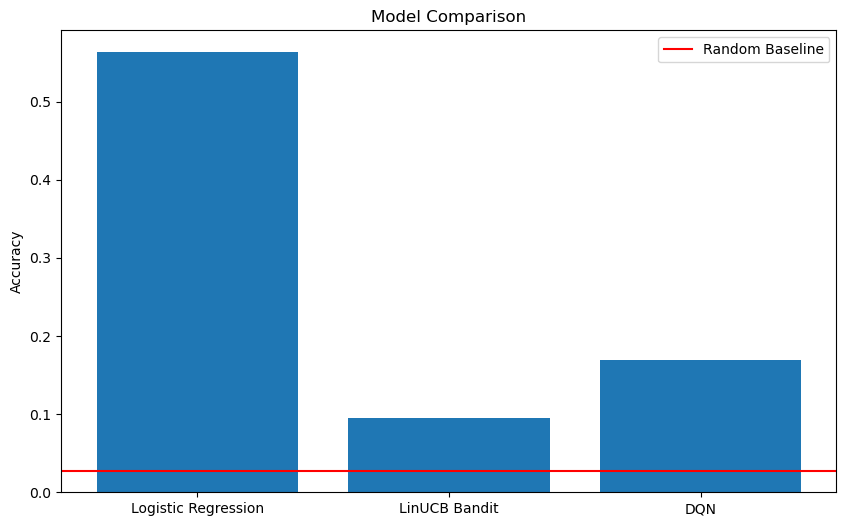

In [27]:
# Compare model performances
models = ['Logistic Regression', 'LinUCB Bandit', 'DQN']
accuracies = [lr_results['accuracy'], bandit_accuracy, dqn_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.axhline(y=random_baseline, color='r', linestyle='-', label='Random Baseline')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.legend()
plt.show()

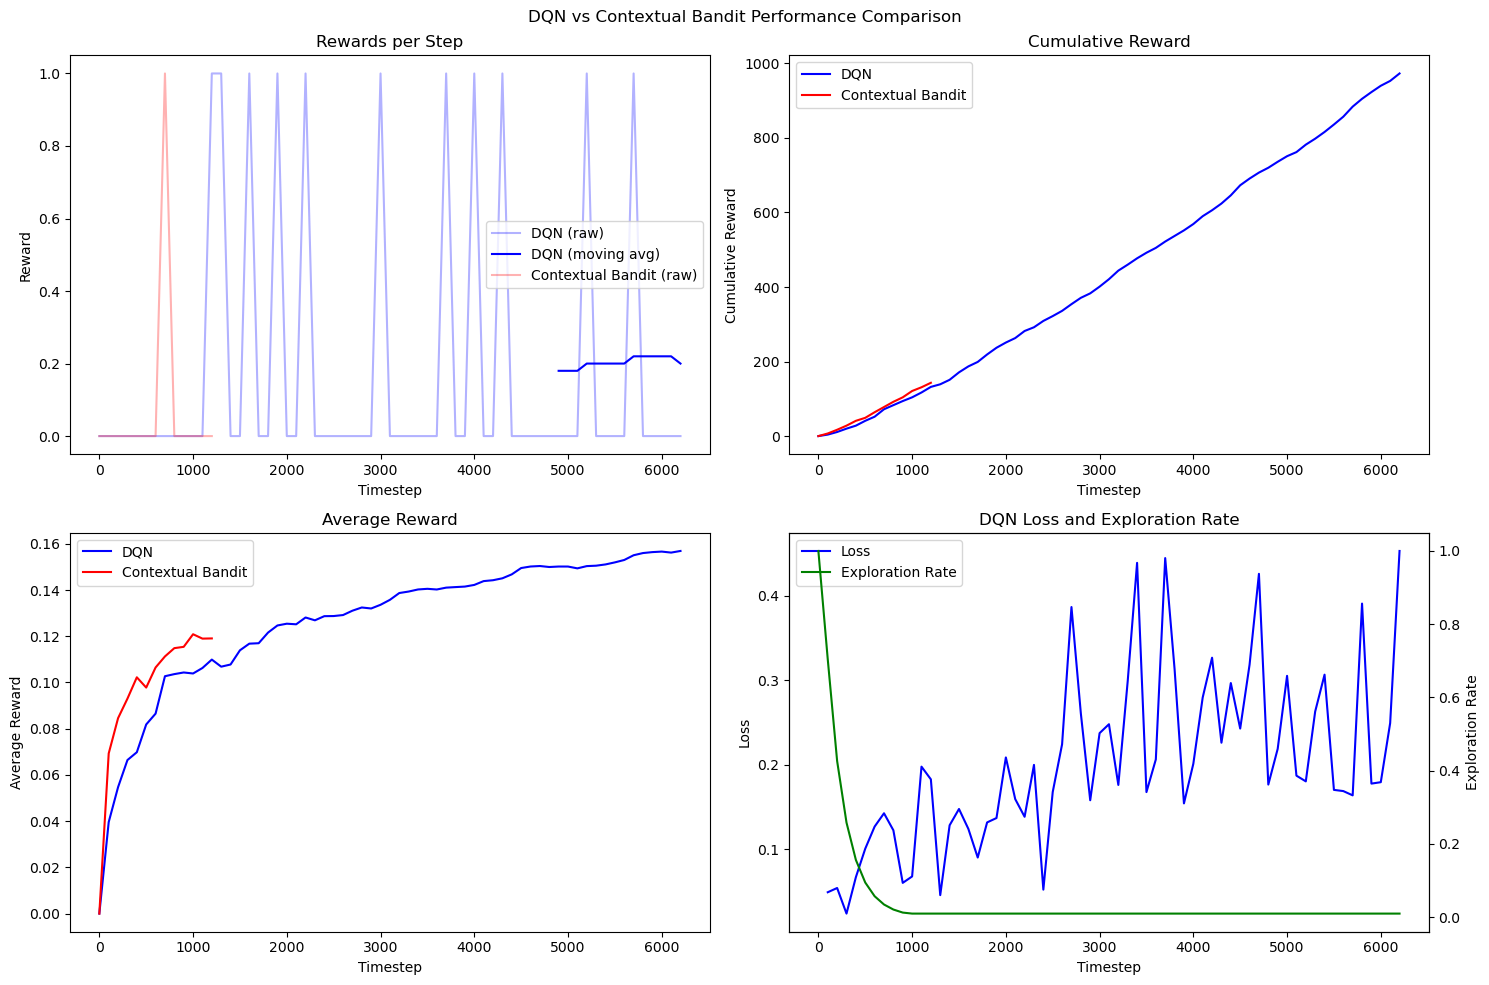

In [28]:
# After training both models, plot the comparison
plot_comparison(logger, save_path='dqn_vs_linucb_comparison.png')